# PyTorch CIFAR-10 categorisation project

1. Explore the data
1. Create a baseline to judge results against
1. Implement a neural network
1. Implement improvements
1. Evaluate different parameters

## 1. Explore the data

In [1]:
import torch
from torch import cuda
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import random

#set random seed for diff sources of randomness
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
rng = np.random.default_rng(seed=0)

In [2]:
data_folder = r"../data"

transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor()])
CIFAR_data = CIFAR10(data_folder, train=True, transform=transform, download=True)

train_dataloader = DataLoader(CIFAR_data,
                          batch_size=4,
                          shuffle=True)

CIFAR_test_data = CIFAR10(data_folder, train=False, transform=transform)

test_dataloader = DataLoader(CIFAR_test_data,
                              batch_size=4,
                              shuffle=True)

Files already downloaded and verified


### Visualise data

The next cell creates train_X, train_y type data which we use to visualise the data and run our benchmark categorisation. The training of Neural Nets uses PyTorch dataloaders and not the objects created in cell below.

To help with initial data exploration, convert the entire data training set to 
tensors.

In [3]:
# to do that explicitly below. Images in DataLoader objects have pixel values
# in (0,1). The CIFAR_data.data has int values in (0,255) so have to convert
# to floats to take mean etc further down
train_imgs = torch.tensor(CIFAR_data.data).float()/255
train_y = torch.tensor(CIFAR_data.targets)
test_imgs = torch.tensor(CIFAR_test_data.data).float()/255
test_y = torch.tensor(CIFAR_test_data.targets)

classes = CIFAR_data.classes

# We need a map to get from index to class name.
# So need to reverse .class_to_idx dict:
labels_map = {}
for key, val in CIFAR_data.class_to_idx.items():
    labels_map[val] = key

Plot random sample of the data:

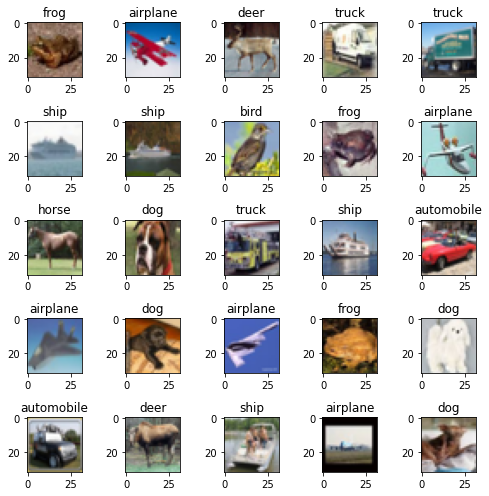

In [4]:
fig, axs = plt.subplots(5,5,figsize=(7,7))

for ax in axs.flatten():
    i = torch.randint(50000, (1,1)).item()
    ax.imshow(train_imgs[i])
    ax.set_title(labels_map[train_y[i].item()])
plt.tight_layout()

## Prepare data for benchmark categorisation

We create the training and validation data and labels.

The data is reshaped to a 4-dimensional tensor. dim 0 corresponds to list of images dim 1 is "depth" - so 3 layers for RGB; dim 2 and 3 are for the 32 pixels height and width of the images. 

We didvide pixel values by 255 so that PyTorch can work with floating point numbers in (0,1).

In [5]:
test_y.shape, test_imgs.shape, train_y.shape, train_imgs.shape

(torch.Size([10000]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([50000, 32, 32, 3]))

## Create a benchmark to judge neural net results against

Will an accuracy of above 10% imply that our neural net is doing better than chance and therefore doing a good job? Maybe.

To create a benchmark, we do a very simple prediction: we calculate the value of the "average" pixel for all the images in each category. Then for each image, we 

First create a benchmark to measure results of training neural net on.

We calculate the average RGB value for each pixel for each category. Then calculate the distance of an image form the average image for each category. Shortest distance is classified as that image. Can we do better than 10% accuracy??

In [6]:
avg_img = torch.zeros((10,32,32,3))
for i in np.arange(10):
    mask = train_y == i
    avg_img[i] = train_imgs[mask].mean(0)
    

Display our "average images". Kinda cool! The automobile and truck look like vehicles coming through the mist and the colours look different for different categories. There will be a lot of confusion between wild animals and cars/trucks for example, but the prediction based on distance from mean image should be quite good.

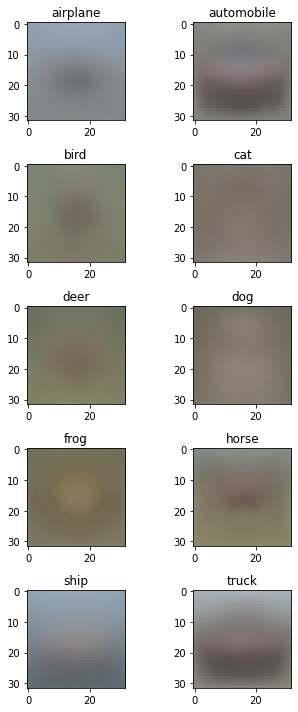

In [7]:
fig, axs = plt.subplots(5,2,figsize=(5,10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(avg_img[i])
    ax.set_title(labels_map[i])
plt.tight_layout()

Test our benchmark prediction. 28%!! Pretty good for just calculating an average. We now need our neural net to outperform 28% accuracy to be any good.

In [8]:
def cifar_distance(a,b): return ((a-b)**2).abs().mean((-1,-2,-3))
def predictions(a): return torch.argmin(a, dim=1)

preds = predictions(cifar_distance(test_imgs[:,None], avg_img[None]))
accuracy = (preds == test_y).sum()/test_imgs.shape[0]
accuracy

tensor(0.2774)

Just for curiousity, let's plot the confusion matrix. Some parts are as we expect from out crude method: it gets confused between deer and frogs (green backgrounds?) and birds and planes (sky?). 

Finally, there were 1000 of each category in the 10,000 test data set. However, our simple rule predicted either airplane or frog 4,500 times. So a lot of images look like the average frog or airplane!

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([2016,  657,  378,  211,  432, 1065, 2485,  622,  885, 1249]))

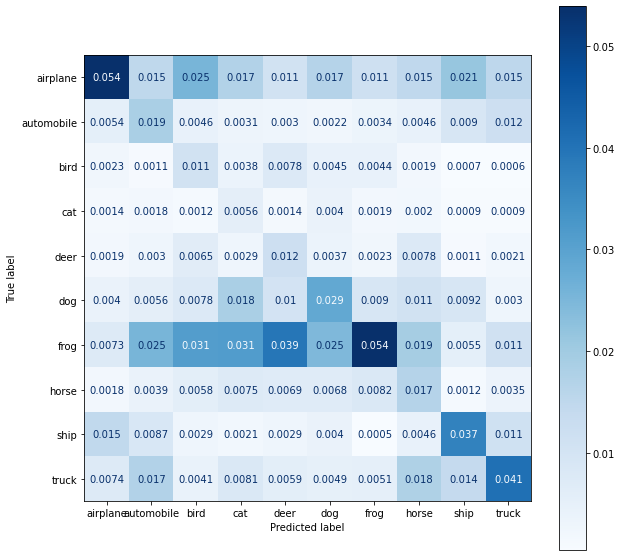

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display(torch.unique(preds, return_counts=True))

cm = confusion_matrix(preds, test_y,
                      normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes
                             )

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues')
ax.grid(False)

## 3. Implement a neural network

Create the initial neural network

In [10]:
device = torch.device('cuda:0' if cuda.is_available() else 'cpu')
device

device(type='cpu')

Prepare the data. To check code runs, I will do a tiny amount of training data.

We also flatten the image data to vectors so that we can feed into a basic NN.

In [11]:
num_epochs = 50
batch_size = 100
learning_rate = 0.005

# I wasn't going to copy Cactus_classification, but defining 'criterion'
# gives good flexibility
criterion = nn.CrossEntropyLoss()

#### Prepare data

The code below is almost an exact copy of cell 2, above. We've recreated to give us the flexibility to have a smaller training and test set whilst running on local machines. We also have target tranform below which one-hot-encodes the labels.

In [12]:
transform = transforms.Compose([transforms.ToTensor(), #transforms.Resize(32),
                                # transforms.Lambda(lambda x: torch.flatten(x))
                               ])
target_transforms = transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float)
                                     .scatter_(0, torch.tensor(y), value=1))

# Prepare 1000 sample training set
CIFAR_data_small = CIFAR10(data_folder, train=True, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_data_small.data = CIFAR_data_small.data[:]
CIFAR_data_small.targets = CIFAR_data_small.targets[:]

# Prepare 1000 sample test set (weird balance, but easy to test)
CIFAR_test_small = CIFAR10(data_folder, train=False, 
                           transform=transform,
                           target_transform=target_transforms,
                           download=False)
CIFAR_test_small.data = CIFAR_test_small.data[:]
CIFAR_test_small.targets = CIFAR_test_small.targets[:]

train_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

test_small_dl = DataLoader(CIFAR_test_small,
                          batch_size=batch_size,
                          shuffle=True)

In [13]:
CIFAR_data_small.data.shape, type(CIFAR_data_small.data), CIFAR_test_small.data.shape

((50000, 32, 32, 3), numpy.ndarray, (10000, 32, 32, 3))

Check that we have one-hot encoded the labels data. Looks like we have!

In [14]:
train_features, train_labels = next(iter(test_small_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].permute(1,2,0)
label = train_labels[0]
# plt.imshow(img)
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([100, 3, 32, 32])
Labels batch shape: torch.Size([100, 10])
Label: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


In [15]:
# Define model

# models should subclass nn.Module. Docs here:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # This flattens the 3 x 32 x 32 image matrices to vectors
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [16]:
# print("Model structure: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Training the model

In [17]:
def train(model, train_small_dl=train_small_dl, test_small_dl=test_small_dl, num_epochs=num_epochs, learning_rate=learning_rate, visible=True):
    
    criterion = nn.CrossEntropyLoss()
    # keeping-track-of-losses 
    train_losses = []
    valid_losses = []
    # set optimiser here - it uses model parameters as input
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)

    for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # training-the-model
        model.train()
        for data, target in train_small_dl:
        # move-tensors-to-GPU / CPU
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
        # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
        # calculate-the-batch-loss
            loss = criterion(output, target_i)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
        # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
        # update-training-loss
            train_loss += loss.item() * data.size(0)
        
    # validate-the-model
        model.eval()
        for data, target in test_small_dl:
        
            data = data.to(device)
            target = target.to(device)
            target_i =torch.argmax(target, dim=1)
            output = model(data)
        
            loss = criterion(output, target_i)
        
        # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
        train_loss = train_loss/len(train_small_dl.sampler)
        valid_loss = valid_loss/len(test_small_dl.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
        if visible:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    

In [18]:
%%time
train(model)

Epoch: 1 	Training Loss: 2.292141 	Validation Loss: 2.280376
Epoch: 2 	Training Loss: 2.270903 	Validation Loss: 2.259605
Epoch: 3 	Training Loss: 2.248343 	Validation Loss: 2.234338
Epoch: 4 	Training Loss: 2.220330 	Validation Loss: 2.203599
Epoch: 5 	Training Loss: 2.187065 	Validation Loss: 2.168387
Epoch: 6 	Training Loss: 2.150435 	Validation Loss: 2.131313
Epoch: 7 	Training Loss: 2.115553 	Validation Loss: 2.097637
Epoch: 8 	Training Loss: 2.084310 	Validation Loss: 2.069108
Epoch: 9 	Training Loss: 2.057786 	Validation Loss: 2.044940
Epoch: 10 	Training Loss: 2.034825 	Validation Loss: 2.022523
Epoch: 11 	Training Loss: 2.014213 	Validation Loss: 2.003997
Epoch: 12 	Training Loss: 1.995435 	Validation Loss: 1.988290
Epoch: 13 	Training Loss: 1.979087 	Validation Loss: 1.968834
Epoch: 14 	Training Loss: 1.963387 	Validation Loss: 1.959038
Epoch: 15 	Training Loss: 1.949715 	Validation Loss: 1.940245
Epoch: 16 	Training Loss: 1.936814 	Validation Loss: 1.928126
Epoch: 17 	Traini

## Test model on validation data

In [19]:
def test(model, test_small_dl=test_small_dl, visible=True):
    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
    # below calculates accuracy. Alex adapted from lab code and
    # it's not very pretty code. I transformed labels from one-
    # hot-encoded to integer labels and did the same for the 
    # softmax output in `predicted`
        for images, labels in test_small_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, dim=1)
            total += labels.size(0)
            labels = torch.argmax(labels, dim=1)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct/total
        if visible:
            print('Test Accuracy of the model: {:.2f} %'.format(100 * accuracy))
    return accuracy

In [20]:
test(model)
# Save 
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model: 40.75 %


# Improvement

The accuracy doesn't look good enough. So let's explore any room for improvement, potentially:
- CNN
- Standard Normalization
- Regularization by dropout/L2
- More data
- tuning parameters: batch size, learning rate, no of epochs, optimizer

## CNN

CNN (convolutional neural network, also called ConvNet) is a popular technique for image classification in machine learning. Unlike traditional fully connected neural network, CNN somehow retains the spatial relationship among features (i.e. pixels) of images. In the below, we will keep the previous neural network structure in the end, but add CNN layers in the beginning. As the image is small, we will start with 3x3 kernel size, 2x2 max pooling, with suitable padding generating same output shape. 

In [21]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()


#train the model
train(net, learning_rate=0.1)

#save
torch.save(net.state_dict(), './cifar_net.pth')

/Users/suenchihang/opt/anaconda3/envs/rosetta/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.223783 	Validation Loss: 2.066364
Epoch: 2 	Training Loss: 2.047690 	Validation Loss: 1.906389
Epoch: 3 	Training Loss: 1.923189 	Validation Loss: 1.837955
Epoch: 4 	Training Loss: 1.805774 	Validation Loss: 1.811316
Epoch: 5 	Training Loss: 1.741843 	Validation Loss: 1.862960
Epoch: 6 	Training Loss: 1.642548 	Validation Loss: 1.535158
Epoch: 7 	Training Loss: 1.581494 	Validation Loss: 1.434889
Epoch: 8 	Training Loss: 1.505733 	Validation Loss: 1.368619
Epoch: 9 	Training Loss: 1.433896 	Validation Loss: 1.334131
Epoch: 10 	Training Loss: 1.381177 	Validation Loss: 1.224450
Epoch: 11 	Training Loss: 1.298224 	Validation Loss: 1.247858
Epoch: 12 	Training Loss: 1.252313 	Validation Loss: 1.147856
Epoch: 13 	Training Loss: 1.193103 	Validation Loss: 1.080310
Epoch: 14 	Training Loss: 1.136807 	Validation Loss: 1.005099
Epoch: 15 	Training Loss: 1.073443 	Validation Loss: 0.981688
Epoch: 16 	Training Loss: 1.036358 	Validation Loss: 0.940260
Epoch: 17 	Traini

In [22]:
test(net)

Test Accuracy of the model: 100.00 %


1.0

In [23]:
# Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
            #https://cs231n.github.io/convolutional-networks/

#define model architecture
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.conv2 = nn.Conv2d(12, 48, 3, padding='same') ##2D convolution layer, 48 channels - kernels of 3x3, 
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net2 = CNN2()


#train the model
train(net2, learning_rate=0.1)

#save
torch.save(net2.state_dict(), './cifar_net2.pth')

Epoch: 1 	Training Loss: 2.292511 	Validation Loss: 2.258652
Epoch: 2 	Training Loss: 2.180149 	Validation Loss: 2.058253
Epoch: 3 	Training Loss: 2.033858 	Validation Loss: 1.900494
Epoch: 4 	Training Loss: 1.943275 	Validation Loss: 1.884676
Epoch: 5 	Training Loss: 1.815385 	Validation Loss: 1.837816
Epoch: 6 	Training Loss: 1.730701 	Validation Loss: 1.624382
Epoch: 7 	Training Loss: 1.653359 	Validation Loss: 1.511921
Epoch: 8 	Training Loss: 1.583430 	Validation Loss: 1.457539
Epoch: 9 	Training Loss: 1.476669 	Validation Loss: 1.347942
Epoch: 10 	Training Loss: 1.425736 	Validation Loss: 1.364871
Epoch: 11 	Training Loss: 1.353831 	Validation Loss: 1.295939
Epoch: 12 	Training Loss: 1.289034 	Validation Loss: 1.231451
Epoch: 13 	Training Loss: 1.227121 	Validation Loss: 1.294402
Epoch: 14 	Training Loss: 1.168342 	Validation Loss: 1.049524
Epoch: 15 	Training Loss: 1.081092 	Validation Loss: 0.977817
Epoch: 16 	Training Loss: 1.010749 	Validation Loss: 0.866036
Epoch: 17 	Traini

In [24]:
test(net2)

Test Accuracy of the model: 100.00 %


1.0

## After adding one convolution layer further, its accuracy is 99.99% or 100.0% 
(running twice to double check results before fixed random seed is added). There should be little room for further improvement and no need for further tuning and testing parameters, except for experiment purpose. Please note that according to PyTorch, completely reproducible results are not guaranteed across PyTorch releases, individual commits, different platforms, or between CPU and GPU executions. (https://pytorch.org/docs/stable/notes/randomness.html).

In [25]:
#simplify by cutting one FC layer of CNN
class CNN1_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1_2 = CNN1_2()


#train the model
train(net1_2, learning_rate=0.1)

#save
torch.save(net1_2.state_dict(), './cifar_net1_2.pth')

#testing vs test set
test(net1_2)

Epoch: 1 	Training Loss: 2.193711 	Validation Loss: 2.041839
Epoch: 2 	Training Loss: 1.962132 	Validation Loss: 1.882853
Epoch: 3 	Training Loss: 1.798579 	Validation Loss: 1.723141
Epoch: 4 	Training Loss: 1.678305 	Validation Loss: 1.777892
Epoch: 5 	Training Loss: 1.598158 	Validation Loss: 1.580768
Epoch: 6 	Training Loss: 1.505320 	Validation Loss: 1.382166
Epoch: 7 	Training Loss: 1.411313 	Validation Loss: 1.298918
Epoch: 8 	Training Loss: 1.338052 	Validation Loss: 1.256435
Epoch: 9 	Training Loss: 1.281751 	Validation Loss: 1.146380
Epoch: 10 	Training Loss: 1.211392 	Validation Loss: 1.121494
Epoch: 11 	Training Loss: 1.136121 	Validation Loss: 1.025015
Epoch: 12 	Training Loss: 1.063583 	Validation Loss: 0.911673
Epoch: 13 	Training Loss: 1.009845 	Validation Loss: 0.830057
Epoch: 14 	Training Loss: 0.939287 	Validation Loss: 0.877866
Epoch: 15 	Training Loss: 0.856947 	Validation Loss: 0.891141
Epoch: 16 	Training Loss: 0.800641 	Validation Loss: 0.799382
Epoch: 17 	Traini

1.0

In [26]:
#simplify by cutting two FC layers of CNN
class CNN1_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

net1_3 = CNN1_3()


#train the model
train(net1_3, learning_rate=0.1)

#save
torch.save(net1_3.state_dict(), './cifar_net1_3.pth')

#testing vs test set
test(net1_3)

Epoch: 1 	Training Loss: 2.296819 	Validation Loss: 2.279371
Epoch: 2 	Training Loss: 2.275928 	Validation Loss: 2.268806
Epoch: 3 	Training Loss: 2.248748 	Validation Loss: 2.230733
Epoch: 4 	Training Loss: 2.231443 	Validation Loss: 2.210817
Epoch: 5 	Training Loss: 2.215579 	Validation Loss: 2.219945
Epoch: 6 	Training Loss: 2.201878 	Validation Loss: 2.230303
Epoch: 7 	Training Loss: 2.186191 	Validation Loss: 2.167523
Epoch: 8 	Training Loss: 2.172050 	Validation Loss: 2.180702
Epoch: 9 	Training Loss: 2.159545 	Validation Loss: 2.148554
Epoch: 10 	Training Loss: 2.151173 	Validation Loss: 2.142551
Epoch: 11 	Training Loss: 2.144335 	Validation Loss: 2.139210
Epoch: 12 	Training Loss: 2.136668 	Validation Loss: 2.121307
Epoch: 13 	Training Loss: 2.126079 	Validation Loss: 2.114740
Epoch: 14 	Training Loss: 2.119911 	Validation Loss: 2.110168
Epoch: 15 	Training Loss: 2.114624 	Validation Loss: 2.105717
Epoch: 16 	Training Loss: 2.107455 	Validation Loss: 2.097932
Epoch: 17 	Traini

0.3511

# Test and Evaluate Parameters

Since the data is balanced among different classes, we can simply use accuracy to evaluate models and ignore confusion matrix. As we have 3 models attaining accuracy of 99.9% or 100.0% in test data, we don't need to worry about over-fitting and regularization and will choose the simplest structure for evaluating different parameters. i.e. the net1_2, which consists of 1 convolutional layer (12 channels, kernels size 3, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (512 nodes) and 1 output layer (10 classes). 

In [27]:
#create a general class of CNN with 1 conv layer, 1 hidden FC layer and 1 output layer
class CNN_variant(nn.Module):
    def __init__(self, k=12, n=512):
        super().__init__()
        self.conv1 = nn.Conv2d(3, k, 3, padding='same') #2D convolution layer, 12 channels - kernels of 3x3, 
        self.pool = nn.MaxPool2d(2, 2)   #2D max pooling
        self.fc1 = nn.Linear(256*k, n)
        self.fc2 = nn.Linear(n, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [28]:
#Create, train and test variants of CNN
CNNs={}
accuracy={}
for k in [3,6,12,24,48]:
    CNNs[k]={}
    accuracy[k]={}
    for n in [128, 256, 512, 1024, 2048]:
        CNNs[k][n]=CNN_variant(k, n)
        train(CNNs[k][n], learning_rate=0.1)
        accuracy[k][n]=test(CNNs[k][n])
        print('done for k='+str(k)+'; n='+str(n))

Epoch: 1 	Training Loss: 2.202442 	Validation Loss: 2.007172
Epoch: 2 	Training Loss: 2.016124 	Validation Loss: 1.900929
Epoch: 3 	Training Loss: 1.878658 	Validation Loss: 1.869287
Epoch: 4 	Training Loss: 1.806908 	Validation Loss: 1.724550
Epoch: 5 	Training Loss: 1.745140 	Validation Loss: 1.702185
Epoch: 6 	Training Loss: 1.702474 	Validation Loss: 1.643097
Epoch: 7 	Training Loss: 1.669756 	Validation Loss: 1.612298
Epoch: 8 	Training Loss: 1.621278 	Validation Loss: 1.550390
Epoch: 9 	Training Loss: 1.585538 	Validation Loss: 1.578800
Epoch: 10 	Training Loss: 1.556714 	Validation Loss: 1.675699
Epoch: 11 	Training Loss: 1.527493 	Validation Loss: 1.484761
Epoch: 12 	Training Loss: 1.501931 	Validation Loss: 1.406092
Epoch: 13 	Training Loss: 1.477707 	Validation Loss: 1.388767
Epoch: 14 	Training Loss: 1.455902 	Validation Loss: 1.340547
Epoch: 15 	Training Loss: 1.417877 	Validation Loss: 1.346076
Epoch: 16 	Training Loss: 1.401179 	Validation Loss: 1.350670
Epoch: 17 	Traini

Epoch: 32 	Training Loss: 0.826280 	Validation Loss: 0.762942
Epoch: 33 	Training Loss: 0.802003 	Validation Loss: 0.722138
Epoch: 34 	Training Loss: 0.762885 	Validation Loss: 0.710116
Epoch: 35 	Training Loss: 0.742629 	Validation Loss: 0.718846
Epoch: 36 	Training Loss: 0.687380 	Validation Loss: 0.666859
Epoch: 37 	Training Loss: 0.655992 	Validation Loss: 0.564921
Epoch: 38 	Training Loss: 0.619634 	Validation Loss: 0.679467
Epoch: 39 	Training Loss: 0.572502 	Validation Loss: 0.533278
Epoch: 40 	Training Loss: 0.547685 	Validation Loss: 0.477455
Epoch: 41 	Training Loss: 0.516436 	Validation Loss: 0.580840
Epoch: 42 	Training Loss: 0.503268 	Validation Loss: 0.338476
Epoch: 43 	Training Loss: 0.435208 	Validation Loss: 0.371738
Epoch: 44 	Training Loss: 0.430201 	Validation Loss: 0.309010
Epoch: 45 	Training Loss: 0.392073 	Validation Loss: 0.311052
Epoch: 46 	Training Loss: 0.395191 	Validation Loss: 0.528309
Epoch: 47 	Training Loss: 0.333948 	Validation Loss: 0.796191
Epoch: 4

Epoch: 12 	Training Loss: 1.295637 	Validation Loss: 1.307356
Epoch: 13 	Training Loss: 1.267748 	Validation Loss: 1.154191
Epoch: 14 	Training Loss: 1.226295 	Validation Loss: 1.147555
Epoch: 15 	Training Loss: 1.192019 	Validation Loss: 1.134344
Epoch: 16 	Training Loss: 1.159846 	Validation Loss: 1.053085
Epoch: 17 	Training Loss: 1.129155 	Validation Loss: 1.081947
Epoch: 18 	Training Loss: 1.077698 	Validation Loss: 1.016667
Epoch: 19 	Training Loss: 1.055272 	Validation Loss: 0.967933
Epoch: 20 	Training Loss: 1.019250 	Validation Loss: 0.941195
Epoch: 21 	Training Loss: 0.987281 	Validation Loss: 1.138657
Epoch: 22 	Training Loss: 0.952675 	Validation Loss: 0.846340
Epoch: 23 	Training Loss: 0.931847 	Validation Loss: 0.865566
Epoch: 24 	Training Loss: 0.881675 	Validation Loss: 0.791783
Epoch: 25 	Training Loss: 0.853874 	Validation Loss: 0.716828
Epoch: 26 	Training Loss: 0.810308 	Validation Loss: 0.712940
Epoch: 27 	Training Loss: 0.782881 	Validation Loss: 0.618784
Epoch: 2

Epoch: 43 	Training Loss: 0.012421 	Validation Loss: 0.010898
Epoch: 44 	Training Loss: 0.010829 	Validation Loss: 0.010727
Epoch: 45 	Training Loss: 0.009472 	Validation Loss: 0.008639
Epoch: 46 	Training Loss: 0.008942 	Validation Loss: 0.007580
Epoch: 47 	Training Loss: 0.007945 	Validation Loss: 0.007424
Epoch: 48 	Training Loss: 0.007575 	Validation Loss: 0.006645
Epoch: 49 	Training Loss: 0.006934 	Validation Loss: 0.006167
Epoch: 50 	Training Loss: 0.006473 	Validation Loss: 0.006005
Test Accuracy of the model: 100.00 %
done for k=6; n=512
Epoch: 1 	Training Loss: 2.165029 	Validation Loss: 2.008245
Epoch: 2 	Training Loss: 1.937137 	Validation Loss: 1.809168
Epoch: 3 	Training Loss: 1.783987 	Validation Loss: 1.725938
Epoch: 4 	Training Loss: 1.683403 	Validation Loss: 1.594356
Epoch: 5 	Training Loss: 1.593904 	Validation Loss: 1.472648
Epoch: 6 	Training Loss: 1.508780 	Validation Loss: 1.430297
Epoch: 7 	Training Loss: 1.440307 	Validation Loss: 1.354586
Epoch: 8 	Training L

Epoch: 23 	Training Loss: 0.608866 	Validation Loss: 0.562066
Epoch: 24 	Training Loss: 0.567454 	Validation Loss: 0.528773
Epoch: 25 	Training Loss: 0.498261 	Validation Loss: 0.411928
Epoch: 26 	Training Loss: 0.445848 	Validation Loss: 0.335335
Epoch: 27 	Training Loss: 0.397047 	Validation Loss: 0.301731
Epoch: 28 	Training Loss: 0.361339 	Validation Loss: 0.484089
Epoch: 29 	Training Loss: 0.314138 	Validation Loss: 0.274640
Epoch: 30 	Training Loss: 0.291923 	Validation Loss: 0.196986
Epoch: 31 	Training Loss: 0.219479 	Validation Loss: 0.201990
Epoch: 32 	Training Loss: 0.202028 	Validation Loss: 0.141284
Epoch: 33 	Training Loss: 0.154497 	Validation Loss: 0.118095
Epoch: 34 	Training Loss: 0.122118 	Validation Loss: 0.237869
Epoch: 35 	Training Loss: 0.134245 	Validation Loss: 0.094090
Epoch: 36 	Training Loss: 0.081515 	Validation Loss: 0.072141
Epoch: 37 	Training Loss: 0.060444 	Validation Loss: 0.049798
Epoch: 38 	Training Loss: 0.079979 	Validation Loss: 0.039379
Epoch: 3

Epoch: 3 	Training Loss: 1.804274 	Validation Loss: 1.735970
Epoch: 4 	Training Loss: 1.696800 	Validation Loss: 1.599202
Epoch: 5 	Training Loss: 1.593955 	Validation Loss: 1.483353
Epoch: 6 	Training Loss: 1.529798 	Validation Loss: 1.453364
Epoch: 7 	Training Loss: 1.441747 	Validation Loss: 1.395224
Epoch: 8 	Training Loss: 1.365966 	Validation Loss: 1.582401
Epoch: 9 	Training Loss: 1.315711 	Validation Loss: 1.192834
Epoch: 10 	Training Loss: 1.256852 	Validation Loss: 1.128468
Epoch: 11 	Training Loss: 1.185404 	Validation Loss: 1.100563
Epoch: 12 	Training Loss: 1.116383 	Validation Loss: 0.994734
Epoch: 13 	Training Loss: 1.069031 	Validation Loss: 0.971977
Epoch: 14 	Training Loss: 1.001789 	Validation Loss: 0.977270
Epoch: 15 	Training Loss: 0.935908 	Validation Loss: 0.795046
Epoch: 16 	Training Loss: 0.860430 	Validation Loss: 0.799543
Epoch: 17 	Training Loss: 0.787614 	Validation Loss: 0.698964
Epoch: 18 	Training Loss: 0.723330 	Validation Loss: 0.620801
Epoch: 19 	Trai

Epoch: 34 	Training Loss: 0.055205 	Validation Loss: 0.045544
Epoch: 35 	Training Loss: 0.049007 	Validation Loss: 0.033636
Epoch: 36 	Training Loss: 0.036802 	Validation Loss: 0.028341
Epoch: 37 	Training Loss: 0.098271 	Validation Loss: 0.032097
Epoch: 38 	Training Loss: 0.032594 	Validation Loss: 0.062138
Epoch: 39 	Training Loss: 0.024833 	Validation Loss: 0.019072
Epoch: 40 	Training Loss: 0.022132 	Validation Loss: 0.017043
Epoch: 41 	Training Loss: 0.017958 	Validation Loss: 0.015496
Epoch: 42 	Training Loss: 0.016090 	Validation Loss: 0.013745
Epoch: 43 	Training Loss: 0.014771 	Validation Loss: 0.012166
Epoch: 44 	Training Loss: 0.013380 	Validation Loss: 0.011347
Epoch: 45 	Training Loss: 0.011765 	Validation Loss: 0.010455
Epoch: 46 	Training Loss: 0.011023 	Validation Loss: 0.009376
Epoch: 47 	Training Loss: 0.010296 	Validation Loss: 0.008881
Epoch: 48 	Training Loss: 0.009384 	Validation Loss: 0.008393
Epoch: 49 	Training Loss: 0.008873 	Validation Loss: 0.007734
Epoch: 5

Epoch: 14 	Training Loss: 0.895703 	Validation Loss: 0.736194
Epoch: 15 	Training Loss: 0.807606 	Validation Loss: 0.743367
Epoch: 16 	Training Loss: 0.747989 	Validation Loss: 0.604620
Epoch: 17 	Training Loss: 0.684319 	Validation Loss: 0.535365
Epoch: 18 	Training Loss: 0.600789 	Validation Loss: 0.504472
Epoch: 19 	Training Loss: 0.528022 	Validation Loss: 0.516029
Epoch: 20 	Training Loss: 0.472212 	Validation Loss: 0.321013
Epoch: 21 	Training Loss: 0.388852 	Validation Loss: 0.303240
Epoch: 22 	Training Loss: 0.326937 	Validation Loss: 0.211279
Epoch: 23 	Training Loss: 0.268656 	Validation Loss: 0.239561
Epoch: 24 	Training Loss: 0.221193 	Validation Loss: 0.269791
Epoch: 25 	Training Loss: 0.171108 	Validation Loss: 0.104385
Epoch: 26 	Training Loss: 0.133825 	Validation Loss: 0.089847
Epoch: 27 	Training Loss: 0.109446 	Validation Loss: 0.220258
Epoch: 28 	Training Loss: 0.079339 	Validation Loss: 0.087357
Epoch: 29 	Training Loss: 0.064853 	Validation Loss: 0.041023
Epoch: 3

Epoch: 45 	Training Loss: 0.011060 	Validation Loss: 0.009836
Epoch: 46 	Training Loss: 0.010335 	Validation Loss: 0.008840
Epoch: 47 	Training Loss: 0.009383 	Validation Loss: 0.008440
Epoch: 48 	Training Loss: 0.008780 	Validation Loss: 0.008095
Epoch: 49 	Training Loss: 0.008171 	Validation Loss: 0.007268
Epoch: 50 	Training Loss: 0.007853 	Validation Loss: 0.006917
Test Accuracy of the model: 100.00 %
done for k=48; n=128
Epoch: 1 	Training Loss: 2.202604 	Validation Loss: 2.054679
Epoch: 2 	Training Loss: 1.963650 	Validation Loss: 1.818612
Epoch: 3 	Training Loss: 1.800147 	Validation Loss: 1.726403
Epoch: 4 	Training Loss: 1.671127 	Validation Loss: 1.624784
Epoch: 5 	Training Loss: 1.568905 	Validation Loss: 1.465782
Epoch: 6 	Training Loss: 1.493799 	Validation Loss: 1.391866
Epoch: 7 	Training Loss: 1.407708 	Validation Loss: 1.346779
Epoch: 8 	Training Loss: 1.343801 	Validation Loss: 1.233696
Epoch: 9 	Training Loss: 1.258987 	Validation Loss: 1.158577
Epoch: 10 	Training L

Epoch: 25 	Training Loss: 0.158610 	Validation Loss: 0.113361
Epoch: 26 	Training Loss: 0.123381 	Validation Loss: 0.069333
Epoch: 27 	Training Loss: 0.083514 	Validation Loss: 0.083284
Epoch: 28 	Training Loss: 0.067396 	Validation Loss: 0.050142
Epoch: 29 	Training Loss: 0.051757 	Validation Loss: 0.035576
Epoch: 30 	Training Loss: 0.039807 	Validation Loss: 0.030406
Epoch: 31 	Training Loss: 0.031621 	Validation Loss: 0.033285
Epoch: 32 	Training Loss: 0.027277 	Validation Loss: 0.022874
Epoch: 33 	Training Loss: 0.022968 	Validation Loss: 0.021874
Epoch: 34 	Training Loss: 0.019030 	Validation Loss: 0.015353
Epoch: 35 	Training Loss: 0.017938 	Validation Loss: 0.014294
Epoch: 36 	Training Loss: 0.015052 	Validation Loss: 0.012370
Epoch: 37 	Training Loss: 0.015026 	Validation Loss: 0.011702
Epoch: 38 	Training Loss: 0.012455 	Validation Loss: 0.010179
Epoch: 39 	Training Loss: 0.010698 	Validation Loss: 0.009337
Epoch: 40 	Training Loss: 0.009510 	Validation Loss: 0.009365
Epoch: 4

In [29]:
#Print in tabular format for accuracy in testing data
rows=[]
count=0
for n in [128, 256, 512, 1024, 2048]:
    rows.append(['n='+str(n)])
    for k in [3,6,12,24,48]:
        rows[count].append("{:.2f}".format(accuracy[k][n]*100)+'%')
    count += 1
        
print('CNN variant accuracy in testing data')
from tabulate import tabulate
print(tabulate(rows, headers=['Accuracy', 'k=3', 'k=6','k=12','k=24','k=48']))


CNN variant accuracy in testing data
Accuracy    k=3     k=6      k=12     k=24     k=48
----------  ------  -------  -------  -------  -------
n=128       83.15%  97.26%   99.98%   99.95%   100.00%
n=256       93.08%  99.66%   100.00%  100.00%  99.99%
n=512       92.57%  100.00%  99.96%   100.00%  100.00%
n=1024      99.99%  99.86%   100.00%  100.00%  100.00%
n=2048      99.35%  99.92%   100.00%  100.00%  100.00%


# Tuning Learning Rate
The first success of achieving accuracy over 99% is done by increasing learning rate (from 0.005 to 0.1) of the first tried CNN model, as it was observed learning too slowly and the accuracy was too low, and based on my analogy with Newton's Method of converging numerical solutions (where "learning rate" is simply 1). Hence, it must have great impact to the accuracry and performance within a limited number of epochs (50 in our case). As we already achieve 100% accuracy, we will focus more on model simplicity (a.k.a. fewer parameters) by tuning learning rate and won't bother with regularization tuning.

In [30]:
train(CNNs[3][128], learning_rate=0.2, visible=False)
test(CNNs[3][128])

Test Accuracy of the model: 95.06 %


0.9506

In [31]:
for k, n in [[6,128],[12,128],[3,256],[6,256],[12,256],[3,512],[6,512],[3,1024]]:
    train(CNNs[k][n], learning_rate=0.2, visible=False)
    print('k='+str(k)+', n='+str(n)+' -- ', end='')
    test(CNNs[k][n])

k=6, n=128 -- Test Accuracy of the model: 100.00 %
k=12, n=128 -- Test Accuracy of the model: 100.00 %
k=3, n=256 -- Test Accuracy of the model: 99.96 %
k=6, n=256 -- Test Accuracy of the model: 100.00 %
k=12, n=256 -- Test Accuracy of the model: 100.00 %
k=3, n=512 -- Test Accuracy of the model: 100.00 %
k=6, n=512 -- Test Accuracy of the model: 100.00 %
k=3, n=1024 -- Test Accuracy of the model: 10.39 %


# Conclusion

If we approximate the number of parameters by ignoring bias term, we can have the following formula:
no. of parameters ~= 9k + 256kn +10n

By minimizing the formula, we can choose (k=6, n=128) as the simplest model which has 100% accuracy.

So among above trials, the simplest model with 100% accuracy is:
1 convolutional layer (6 channels, kernels size 3, stride 1, padding 1, with MaxPool(2,2) then RELU), followed by 1 hidden fully connected layer (128 nodes, RELU) and 1 output layer (10 classes), at learning rate = 0.2 using SGD.

Note: learning rate of 0.2 may cause some models to deteriorate sharply in accuracy in certain random states.
